In [1]:
import scipy.stats as stats
import pandas as pd
import tabulate
import sys 
sys.path.insert(1,"../utils")
import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn
import patsy
import sklearn.linear_model as linear
import numpy.random as random
from collections import defaultdict

# Functions

The following are a functions that will be used to perform our linear regression model.

In [2]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))


    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(airBnB[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

In [3]:
def power(x):
    return np.power(float(x), 2)

def log( x):
    return np.log(x) if x>0 else 0

In [4]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [5]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

In [6]:
def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

In [7]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [8]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=1):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [9]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [10]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=1, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [11]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [12]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

# Model

## Load Data

In [13]:
airBnb_csv = "../datasets/airbnb_selected_variables.csv"
airBnB = pd.read_csv(airBnb_csv)
airBnB['room_type'] = airBnB['room_type'].str.replace('/','_')
airBnB['room_type'] = airBnB['room_type'].str.replace(' ','_')
airBnB['host_response_time'] = airBnB['host_response_time'].str.replace(' ','_')

## Dummies

In [14]:
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["host_is_superhost"], prefix="superhost")], axis=1)
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["host_response_time"], prefix="host_response_time")], axis=1)
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["room_type"], prefix="room_type")], axis=1)
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["property_type"], prefix="property_type")], axis=1)
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["instant_bookable"], prefix="instant_bookable")], axis=1)
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["neighborhood_label"], prefix="neighborhood")], axis=1)
airBnB = pd.concat([airBnB, pd.get_dummies(airBnB["bathroom_type"], prefix="bath_type")], axis=1)

In [15]:
airBnB.head()

,Unnamed: 0,price,bedrooms,beds,accommodates,host_is_superhost,host_response_time,room_type,property_type,instant_bookable,...,property_type_hotel,property_type_house,property_type_unusual,instant_bookable_f,instant_bookable_t,neighborhood_high,neighborhood_low,neighborhood_medium,bath_type_private,bath_type_shared
0,0,20.0,1,1,2,f,within_an_hour,Private_room,house,f,...,0,1,0,1,0,0,0,1,1,0
1,1,185.0,3,3,8,f,within_an_hour,Entire_home_apt,house,f,...,0,1,0,1,0,0,1,0,0,1
2,2,221.0,2,2,4,f,within_an_hour,Entire_home_apt,apt,f,...,0,0,0,1,0,0,0,1,0,1
3,3,142.0,1,2,3,t,within_an_hour,Entire_home_apt,house,t,...,0,1,0,0,1,0,0,1,0,1
4,4,398.0,2,3,5,f,within_an_hour,Entire_home_apt,apt,t,...,0,0,0,0,1,1,0,0,0,1


## Correlations

In [16]:
used = ['bedrooms', 'beds', 'accommodates', 'host_response_rate', 'host_acceptance_rate', 'number_of_reviews', 
        'review_scores_rating', 'reviews_per_month', 'num_baths', 
        'superhost_f', 'superhost_t', 'host_response_time_a_few_days_or_more', 'host_response_time_within_a_day', 
        'host_response_time_within_a_few_hours', 'host_response_time_within_an_hour', 'room_type_Entire_home_apt', 
        'room_type_Private_room', 'room_type_Shared_room', 'property_type_apt', 'property_type_hotel', 
        'property_type_house', 'property_type_unusual', 'instant_bookable_f', 'instant_bookable_t', 'neighborhood_high', 
        'neighborhood_low', 'neighborhood_medium', 'bath_type_private', 'bath_type_shared']

correlations(airBnB, 'price', used)

,feature,r,rho
0,bedrooms,0.391956,0.415564
1,beds,0.421871,0.456713
2,accommodates,0.508050,0.553506
3,host_response_rate,0.023571,0.034322
4,host_acceptance_rate,0.102784,0.142665
5,number_of_reviews,-0.051700,-0.035164
6,review_scores_rating,-0.052113,0.003706
7,reviews_per_month,0.000882,0.011596
8,num_baths,0.472966,0.461407
9,superhost_f,-0.045080,-0.062989


Bedrooms, beds, accommodates, and number of baths have strong relationships with price.

## All in Model

In [17]:
model = "price ~ bedrooms + beds + accommodates + host_response_rate + host_acceptance_rate + number_of_reviews + review_scores_rating + reviews_per_month + num_baths + superhost_t + host_response_time_a_few_days_or_more + host_response_time_within_a_day + host_response_time_within_a_few_hours + room_type_Entire_home_apt + room_type_Private_room + property_type_apt + property_type_hotel + property_type_house + instant_bookable_t + neighborhood_high + neighborhood_low + bath_type_private"
result1 = models.bootstrap_linear_regression(model, data=airBnB)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-77.37,-128.34,-36.03
bedrooms,$\beta_{1}$,12.38,8.61,15.73
beds,$\beta_{2}$,-4.20,-9.70,0.87
accommodates,$\beta_{3}$,14.38,10.62,18.45
host_response_rate,$\beta_{4}$,-0.10,-0.19,0.00
host_acceptance_rate,$\beta_{5}$,0.19,0.08,0.31
number_of_reviews,$\beta_{6}$,-0.06,-0.10,-0.01
review_scores_rating,$\beta_{7}$,-5.63,-6.77,-4.31
reviews_per_month,$\beta_{8}$,-0.19,-3.99,2.77


## Improving the Model

In [18]:
predictions = {"bedrooms": "+", "beds": "+", "accommodates": "+", "host_response_rate": "+", "host_acceptance_rate": "+", 
               "number_of_reviews": "+", "review_scores_rating": "+", "reviews_per_month": "+", "num_baths": "+", 
               "superhost_t": "+", "host_response_time_a_few_days_or_more": "+", "host_response_time_within_a_day": "-",
               "host_response_time_within_a_few_hours": "+", 
               "room_type_Entire_home_apt": "+",
               "room_type_Private_room": "+", 
               "property_type_apt": "+", 
               
               "property_type_hotel": "+", 
               "property_type_house": "-", "property_type_unusual": "-", "instant_bookable_f": "-", 
               "instant_bookable_t": "+", "neighborhood_high": "+", "neighborhood_low": "+", "neighborhood_medium": "+", 
               "bath_type_private": "+", "bath_type_shared": "-"}
models.evaluate_coefficient_predictions(predictions, result1)

bedrooms P(>0)=1.000 (strong)
beds P(>0)=0.090 (weak)
accommodates P(>0)=1.000 (strong)
host_response_rate P(>0)=0.030 (weak)
host_acceptance_rate P(>0)=1.000 (strong)
number_of_reviews P(>0)=0.020 (weak)
review_scores_rating P(>0)=0.000 (weak)
reviews_per_month P(>0)=0.410 (mixed)
num_baths P(>0)=1.000 (strong)
superhost_t P(>0)=1.000 (strong)
host_response_time_a_few_days_or_more P(>0)=0.330 (weak)
host_response_time_within_a_day P(<0)=1.000 (strong)
host_response_time_within_a_few_hours P(>0)=0.000 (weak)
room_type_Entire_home_apt P(>0)=1.000 (strong)
room_type_Private_room P(>0)=1.000 (strong)
property_type_apt P(>0)=1.000 (strong)
property_type_hotel P(>0)=1.000 (strong)
property_type_house P(<0)=0.030 (weak)
instant_bookable_t P(>0)=1.000 (strong)
neighborhood_high P(>0)=1.000 (strong)
neighborhood_low P(>0)=0.130 (weak)
bath_type_private P(>0)=0.980 (strong)


<!-- page 762 Fundamentals -->

The coefficient of determination ($R^2$) is 37% which is low.
The error ($\sigma$) has been cut more than in half compared to the Null model (7.81) to 104.04.

__Improving the Model__

| coefficient           | expected | credible | decision |
|-----------------------|----------|----------|----------|
| bedrooms              | yes      | yes       | keep     |
| beds                  | no      | no      | remove     |
| accommodates          | yes      | yes      | keep     |
| host_response_rate    | no       | yes      | examine  |
| host_acceptance_rate	| yes      | yes      | keep     |
| number_of_reviews  	| no       | yes       | examine   |
| review_scores_rating	| no       | yes      | examine  |
| reviews_per_month   	| yes       | no       | keep   |
| num_baths             | yes      | yes      | keep     |
| superhost_t 	        | yes      | yes      | keep     |
|host_response_time_a_few_days_or_more | yes | yes | keep |
|host_response_time_within_a_day       | yes | yes | keep |
|host_response_time_within_a_few_hours | yes | yes | keep |
|room_type_Entire_home_apt             | yes | yes | keep |
|room_type_Private_room | yes | yes | keep |
|property_type_apt | yes | yes | keep |
| property_type_hotel 	| yes      | yes      | keep     |
| property_type_house 	| yes      | yes      | keep     |
| instant_bookable_t    | yes      | yes      | keep     |
| neighborhood_high     | yes      | yes      | keep     |
| neighborhood_low  	| yes      | no      | keep     |
| bath_type_private 	| yes      | no      | keep     |



The next iteration is taking out all the weakly correlated variables to see if this improves that model.  

* reviews_per_month
* neighborhood_low
* host_response_time_a_few_days_or_more

In [19]:
model1 = "price ~ bedrooms + beds + accommodates + host_response_rate + host_acceptance_rate + number_of_reviews + review_scores_rating + num_baths + superhost_t + host_response_time_within_a_day + host_response_time_within_a_few_hours + room_type_Entire_home_apt + room_type_Private_room + property_type_apt + property_type_hotel + property_type_house + instant_bookable_t + neighborhood_high + bath_type_private"
result = models.bootstrap_linear_regression(model1, data=airBnB)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-78.59,-112.91,-42.52
bedrooms,$\beta_{1}$,12.39,8.72,16.74
beds,$\beta_{2}$,-4.26,-8.79,2.14
accommodates,$\beta_{3}$,14.38,10.86,17.90
host_response_rate,$\beta_{4}$,-0.09,-0.22,0.00
host_acceptance_rate,$\beta_{5}$,0.19,0.11,0.31
number_of_reviews,$\beta_{6}$,-0.06,-0.09,-0.03
review_scores_rating,$\beta_{7}$,-5.68,-7.21,-4.41
num_baths,$\beta_{8}$,42.39,31.86,55.78


The value for $\sigma$ decreases from 104.00 to 103.99.

## Residuals

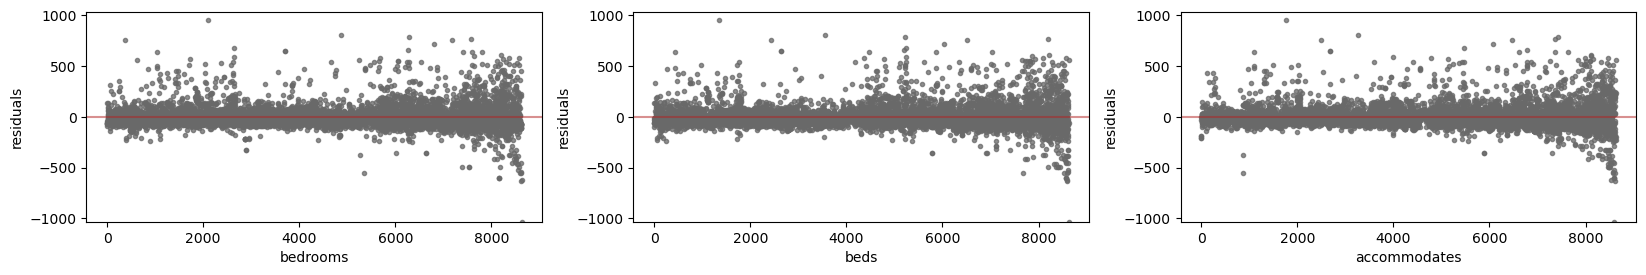

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [20]:
plot_residuals(result1, ["bedrooms", "beds", "accommodates"])

For the variables `bedrooms`, `beds`, and `accommodates`, the residuals tend to get larger as the values get larger. The errors increase as these variables increase, which is known as heteroskedacity.

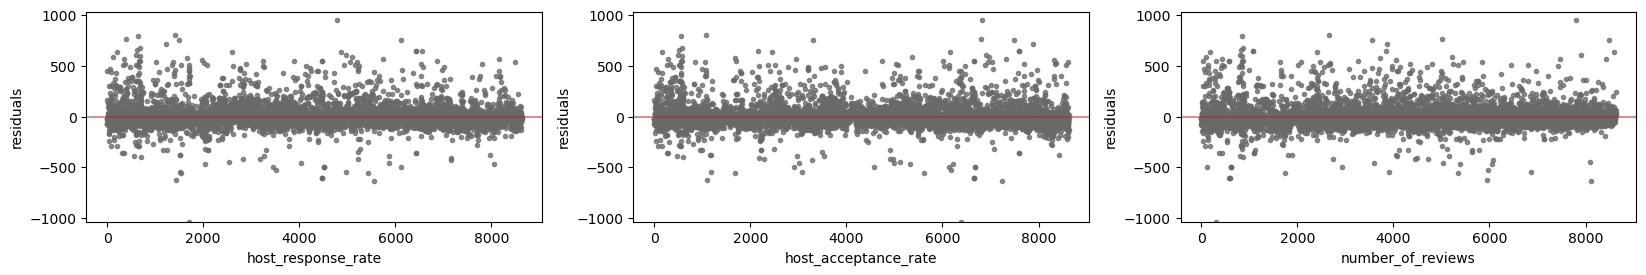

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [21]:
plot_residuals(result1, ["host_response_rate", "host_acceptance_rate", "number_of_reviews"])

The residuals for `host_response_rate`, `host_acceptance_rate`, and `number_of_reveiws` do not appear to have a specific patter, though there is a wide spread of values.

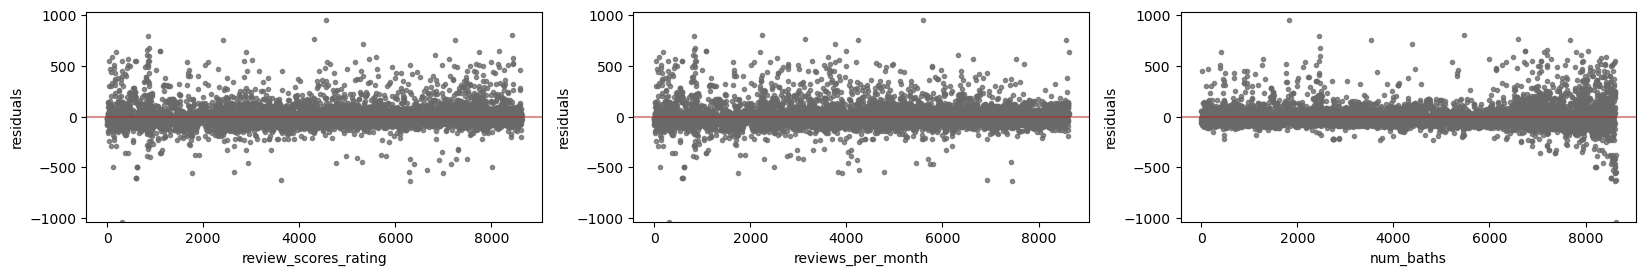

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [22]:
plot_residuals(result1, ["review_scores_rating", "reviews_per_month", "num_baths"])

Once again, we see heteroskedacity in the plot of the residuals for `num_baths`. There is an unequal variance in our model, so our model may be over- or under-specified.

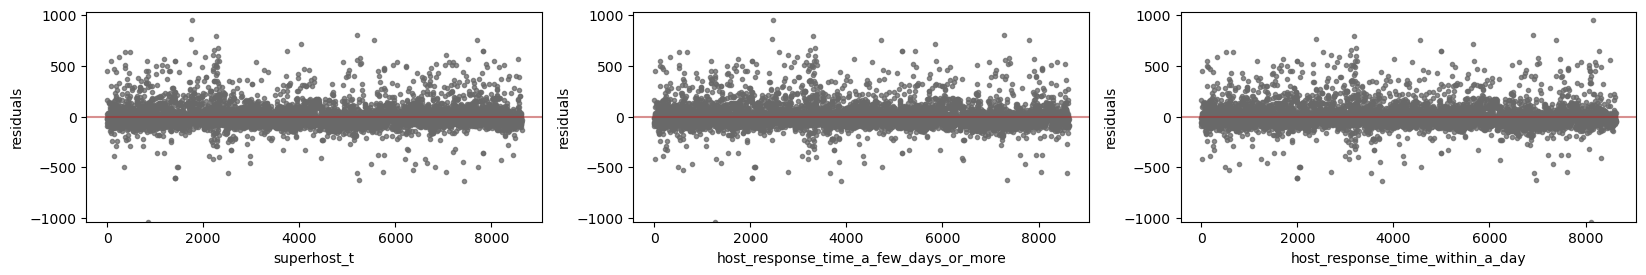

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [23]:
plot_residuals(result1, ["superhost_t", "host_response_time_a_few_days_or_more", "host_response_time_within_a_day"])

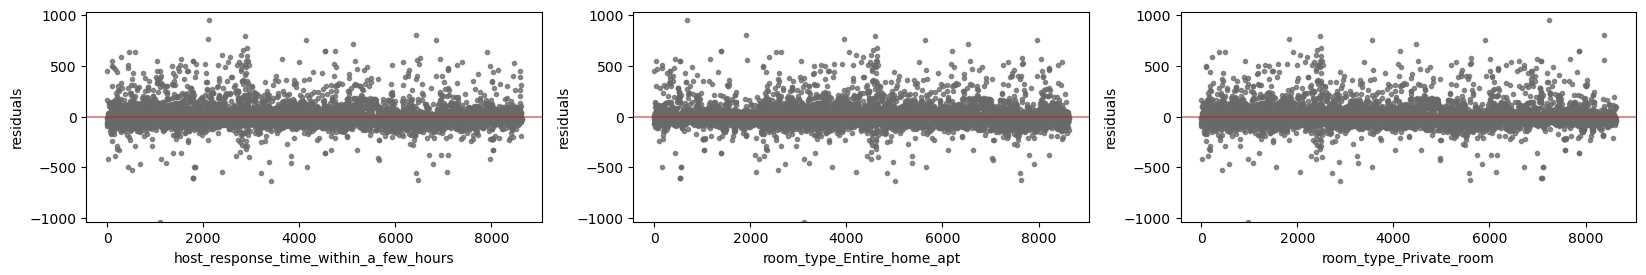

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [24]:
plot_residuals(result1, ["host_response_time_within_a_few_hours", "room_type_Entire_home_apt", "room_type_Private_room"])

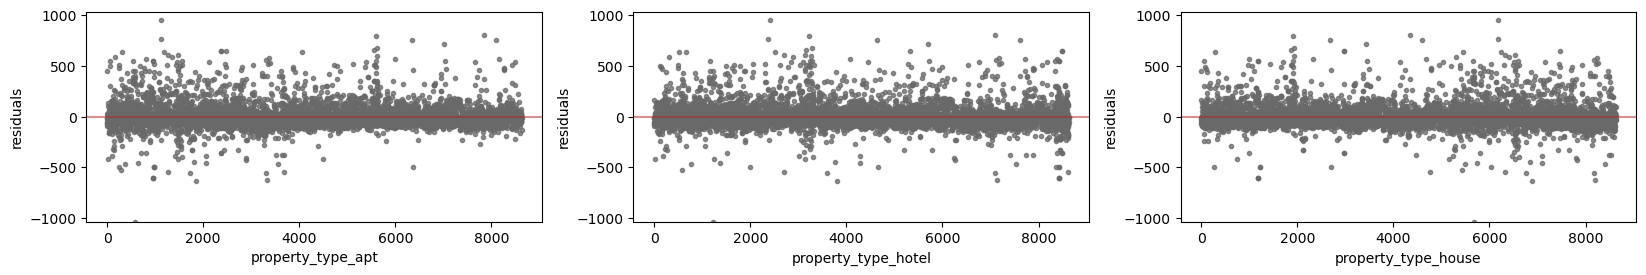

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [25]:
plot_residuals(result1, ["property_type_apt", "property_type_hotel", "property_type_house"])

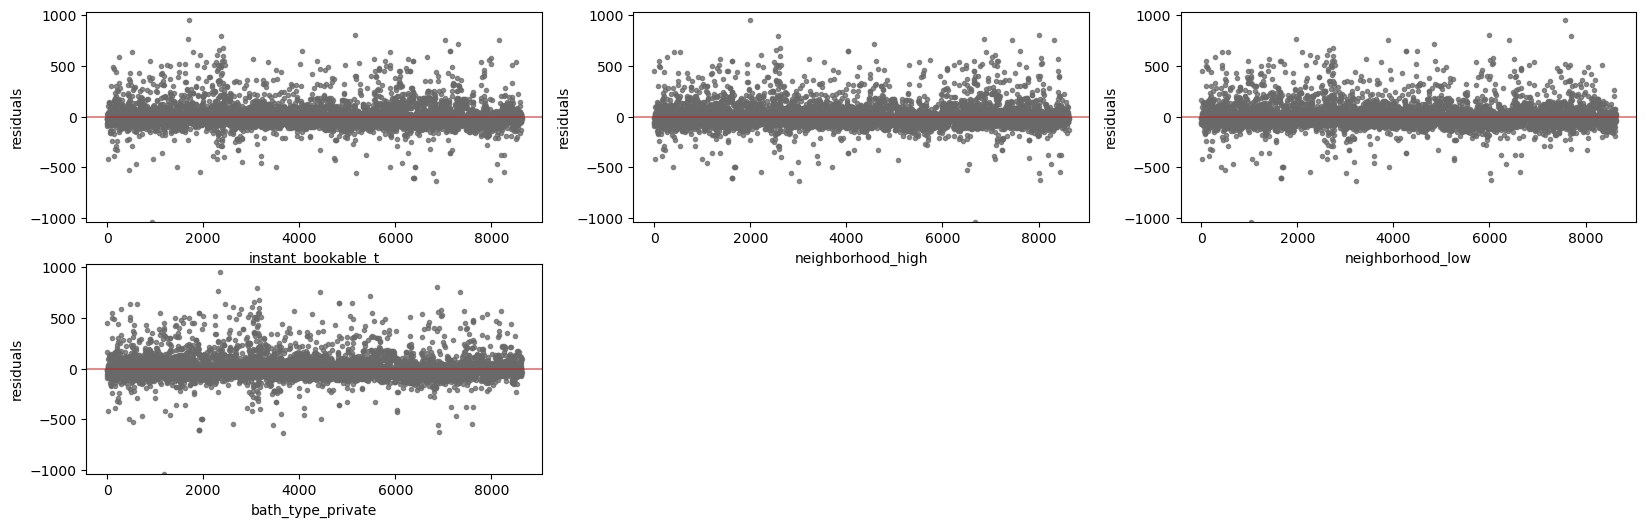

array([ -58.29519882,  -97.2810143 ,  -15.11991052, ..., -127.7536546 ,
        -12.60338031,  -28.65220026])

In [26]:
plot_residuals(result1, ["instant_bookable_t", "neighborhood_high", "neighborhood_low", "bath_type_private"])

## Transformations

Some of the graphs above are displaying heteroskedasticity. I'm going to log:

* bedrooms
* beds 
* accomodates
* num_baths

I'm also going to log some of the weak variables to lessen their influence:

* host_response_rate
* host_acceptance_rate
* number_of_reviews
* review_scores_rating
* reviews_per_month
* host_response_time_a_few_days_or_more

In [27]:
airBnB[ "bedrooms_log"] = airBnB["bedrooms"].apply(log)
airBnB[ "beds_log"] = airBnB["beds"].apply(log)
airBnB[ "accommodates_log"] = airBnB["accommodates"].apply(log)
airBnB[ "num_baths_log"] = airBnB["num_baths"].apply(log)

airBnB[ "host_response_rate_log"] = airBnB["host_response_rate"].apply(log)
airBnB[ "host_acceptance_rate_log"] = airBnB["host_acceptance_rate"].apply(log)
airBnB[ "number_of_reviews_log"] = airBnB["number_of_reviews"].apply(log)
airBnB[ "review_scores_rating_log"] = airBnB["review_scores_rating"].apply(log)

In [28]:
model2 = "price ~ bedrooms_log + beds_log + accommodates_log + host_response_rate_log + host_acceptance_rate_log + number_of_reviews_log + review_scores_rating_log + num_baths_log + superhost_t + host_response_time_within_a_day + host_response_time_within_a_few_hours + room_type_Entire_home_apt + room_type_Private_room + property_type_apt + property_type_hotel + property_type_house + instant_bookable_t + neighborhood_high  + bath_type_private"
result = models.bootstrap_linear_regression(model2, data=airBnB)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-21.03,-57.76,16.59
bedrooms_log,$\beta_{1}$,19.16,11.67,26.12
beds_log,$\beta_{2}$,8.72,1.10,15.61
accommodates_log,$\beta_{3}$,40.61,34.45,47.02
host_response_rate_log,$\beta_{4}$,-2.52,-4.81,-0.62
host_acceptance_rate_log,$\beta_{5}$,4.73,2.56,6.81
number_of_reviews_log,$\beta_{6}$,-5.14,-6.54,-3.37
review_scores_rating_log,$\beta_{7}$,-11.34,-15.94,-6.83
num_baths_log,$\beta_{8}$,106.38,95.08,116.75


Logging the variables has lowered our sigma to 102.78 and raised R squared to .38.

## Interaction Terms

The first interaction term I want to try is number of beds per bedroom.  I think more beds per bedroom will have a negative effect on the price.

In [29]:
model3 = "price ~ bedrooms_log + beds_log + accommodates_log + host_response_rate_log + host_acceptance_rate_log + number_of_reviews_log + review_scores_rating_log + num_baths_log + superhost_t + host_response_time_within_a_day + host_response_time_within_a_few_hours + room_type_Entire_home_apt + room_type_Private_room + property_type_apt + property_type_hotel + property_type_house + instant_bookable_t + neighborhood_high + bath_type_private + bedrooms:beds"
result = models.bootstrap_linear_regression(model3, data=airBnB)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-21.00,-64.85,15.44
bedrooms_log,$\beta_{1}$,20.32,6.92,29.91
beds_log,$\beta_{2}$,9.81,-1.74,20.21
accommodates_log,$\beta_{3}$,40.61,34.19,46.41
host_response_rate_log,$\beta_{4}$,-2.53,-4.74,-0.70
host_acceptance_rate_log,$\beta_{5}$,4.76,2.38,7.73
number_of_reviews_log,$\beta_{6}$,-5.15,-6.76,-3.28
review_scores_rating_log,$\beta_{7}$,-11.36,-15.21,-7.84
num_baths_log,$\beta_{8}$,107.29,94.06,119.63


That didn't change the R squared or sigma.  I'll try bathrooms per bedroom now.

In [30]:
model3 = "price ~ bedrooms_log + beds_log + accommodates_log + host_response_rate_log + host_acceptance_rate_log + number_of_reviews_log + review_scores_rating_log + num_baths_log + superhost_t + host_response_time_within_a_day + host_response_time_within_a_few_hours + room_type_Entire_home_apt + room_type_Private_room + property_type_apt + property_type_hotel + property_type_house + instant_bookable_t + neighborhood_high + bath_type_private + bedrooms:num_baths"
result = models.bootstrap_linear_regression(model3, data=airBnB)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-20.31,-55.81,24.67
bedrooms_log,$\beta_{1}$,21.86,4.14,31.70
beds_log,$\beta_{2}$,9.03,0.33,16.20
accommodates_log,$\beta_{3}$,40.54,33.44,46.39
host_response_rate_log,$\beta_{4}$,-2.56,-4.51,-0.62
host_acceptance_rate_log,$\beta_{5}$,4.79,2.38,7.55
number_of_reviews_log,$\beta_{6}$,-5.14,-6.53,-3.65
review_scores_rating_log,$\beta_{7}$,-11.40,-16.87,-7.56
num_baths_log,$\beta_{8}$,111.88,77.39,124.46


That made the model a little better.  R squared is higher and sigma is a little lower.

I want to try one last interaction term which is bedrooms per accomodates.

In [31]:
model4 = "price ~ bedrooms_log + beds_log + accommodates_log + host_response_rate_log + host_acceptance_rate_log + number_of_reviews_log + review_scores_rating_log + num_baths_log + superhost_t + host_response_time_within_a_day + host_response_time_within_a_few_hours + room_type_Entire_home_apt + room_type_Private_room + property_type_apt + property_type_hotel + property_type_house + instant_bookable_t + neighborhood_high + bath_type_private + bedrooms:num_baths + bedrooms:accommodates"
result = models.bootstrap_linear_regression(model4, data=airBnB)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-14.80,-50.32,14.58
bedrooms_log,$\beta_{1}$,11.39,0.75,20.72
beds_log,$\beta_{2}$,5.46,-1.74,14.23
accommodates_log,$\beta_{3}$,27.16,19.63,35.43
host_response_rate_log,$\beta_{4}$,-2.64,-4.98,-0.74
host_acceptance_rate_log,$\beta_{5}$,4.65,1.84,6.91
number_of_reviews_log,$\beta_{6}$,-4.85,-6.69,-3.35
review_scores_rating_log,$\beta_{7}$,-12.01,-16.16,-7.02
num_baths_log,$\beta_{8}$,116.32,95.03,127.40


That yielded a slight improvment in our sigma to 102.23.

## Model Evaluation and Improvement

There are a number of ways to evaluated the model we came up with. One of the ways to evaluate our model is to compared it to the null model. Has the $\sigma$ decrease? The other way is to  see the bias/variance tradeoff via the use of learning curves and cross validations to improve the metrics of our model ($\sigma$). Ultimately, this tool helps use determine how we might go about improving our model's performance. That is, 

1. Do we need more observations? 
2. Are the number of inputs enough? Do we need to drop/ add or capture new variables? 
3. Have we regularize our model? That is, are we underfiiting or overfitting our model? 
4. Do we need to change the model to something else? Poisson? Logistic? 


### Null Model Comparison 

From the null model, we know the $\sigma$ of this particular model was 130.82. The $\sigma$ for the model we came up with is 102.23. That is a significant improvement while keeping a $R^2$ of .39. 


### Learning Curves

With learning curves and assuming with have a final model, the data that we train our model on must come from the same distribution the data we hope to apply the model to. For this reason, the application of cross validation, which is similar to bootstrapping, allows us to divide our data into sections or folds and use test sets and training set to come up with estimates of the MSE ($\sigma$). This way, after we have an estimate of what our $\sigma$ is, the simulation of this distribution if we were to get more observations allows use to see if getting more data will help. 

So first thing, let us 10 fold cross validate our data: 

In [32]:
result_cross = cross_validation(models.linear_regression, model4, airBnB, lambda r: (r["sigma"], r["r_squared"]))
print(result_cross)

[(103.82326108095249, 0.4372971633220979), (102.94802639549333, 0.3562198894524574), (107.11950799756451, 0.423684402931108), (108.32920959893326, 0.36395991240094727), (100.64821701945112, 0.40127674235929034), (103.29620909383411, 0.40330004775589356), (105.21544918862213, 0.3568879115318998), (97.93523938672142, 0.43299883927731186), (106.96686890513976, 0.2870462604061539), (97.58183676884624, 0.42272635160811833)]


Our results seem promising. The smallest $\sigma$ we can potentially see is 95.52 with an $R^2$. This is an even better improvement from our null and final model. Let's find the learning curves:

In [33]:
result_learningcurv = learning_curves(models.linear_regression, model4, airBnB, lambda r: r["sigma"])

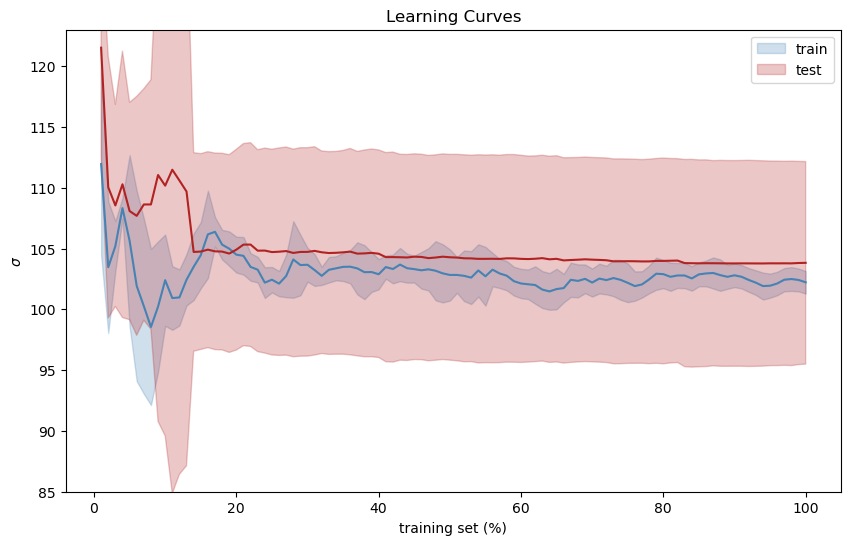

In [34]:
plot_learning_curves(result_learningcurv, r"$\sigma$", zoom=True)

Bias/Variance tradeoff: 

We can see at the start, when we're using only a very small fraction of the data set , that the difference in MSE between the training set (blue dot) and test set (red dot) is relatively large. This is called the *generalization error*.

At the same time, the MSE on the test set (red line) is decreasing. If we have more data to build a model with, the model will generalize better and thus do better on the test set. That's what we want.

At 8627 data points, the far right, we're using all of the data we have. The lines have more or less converged. This means that getting more data won't help us to improve this model. Note that that means *this* model...including its hyperparameters, regularization, etc. If we change those, we may or may not need more data. But for now, it appears we don't.

This makes sense. The model is being fit using relatively little training data so it's overfitting and then not performing very well on the test data. As we increase the amount of our data we're using, the MSE on the training set (blue line) starts to increase. This also makes sense because we're building a more general model as we have more data to generalize over.
To bring this back to the bias/variance trade off, when the two curves are far apart, we're in the *high variance* area. We're overfitting our model to the (small) amount of data. In the limit, with two data points for the training set, we fit the data perfectly.

When the two curves are closer together, we're in the *high bias* area. The more data we have, the more the error comes from the form of the model. In the limit, the new data simply isn't change the model much or at all.

Assuming this is as far as it goes with the model we build, let's make some predictions.


## Predictions 

In order to create predictions from the model, we must create a vector that simulates the circumstance for which we would want to predict the price. That is, if we want the price for a place that has:

1. Skip (1 is inserted for the intercept)
2. 2 bedrooms
3. 3 beds
4. 4 accomodates
5. 98 host_response_rate
6. 88 host_aceptantce_rate
7. 25 number of review
8. 4.8 review_scores_rating
9. 1 num_baths
10. Is a superhost. superhost_t = 1 (True)
11. host_response_time_within_a_day = 1 (True)
12. host_response_time_within_a_few_hours = 0 (False since responds within a day)
13. room_type_Entire_home_apt = 1 (True)
14. room_type_Private_room = 0 (False since room type is apt)
15. property_type_apt = 1 (True)
16. property_type_hotel = 0 (False since property type is apt)
17. property_type_house = 0 (False since property type is apt)
18. instant_bookable_t = 1 (True)
19. neighborhood_high = 1 (True)
20. bath_type_private = 1 (True)
21. bedrooms:num_baths = 2 ; 2 is the number of bedrooms and there is 1 bath (2x1 = 2)
22. bedrooms:accommodates 8; 2 is the number of bedrooms and there is room for 4 accomodate (2x4 = 8) 


In [35]:
prediction = result["model"].predict([[10,2,3,4,98,88,25,4.8,1,1,1,0,1,0,1,0,0,1,1,1,2,8]])
print(prediction)

[[272.68332955]]


We get an Airbnb that should cost around \\$272.68 dollars. Let's try another circumstance: 

1. Skip (1 is inserted for the intercept)
2. 1 bedroom
3. 2 beds
4. 4 accomodates
5. 98 host_response_rate
6. 88 host_aceptantce_rate
7. 25 number of review
8. 4.8 review_scores_rating
9. 2 num_baths
10. Is a superhost. superhost_t = 1 (True)
11. host_response_time_within_a_day = 0 (False since responds within hrs)
12. host_response_time_within_a_few_hours = 1 (True)
13. room_type_Entire_home_apt = 1 (True)
14. room_type_Private_room = 0 (False since room type is apt)
15. property_type_apt = 0 (False since property type is hotel)
16. property_type_hotel = 1 (True)
17. property_type_house = 0 (False since property type is hotel)
18. instant_bookable_t = 1 (True)
19. neighborhood_high = 0 (False)
20. bath_type_private = 1 (True)
21. bedrooms:num_baths = 6 ; 3 is the number of bedrooms and there is 2 bath (3x2 = 6)
22. bedrooms:accommodates = 9 ; 3 is the number of bedrooms and there is room for 3 accomodate (3x3 = 9) 

In [36]:
prediction2 = result["model"].predict([[10,1,2,4,98,88,25,4.8,1,1,0,1,1,0,0,1,0,1,0,1,6,9]])
print(prediction2)

[[338.03620013]]


We get an Airbnb that should cost around \\$338.04. Let's try another circumstance: 

1. Skip (1 is inserted for the intercept)
2. 1 bedrooms
3. 2 beds
4. 1 accomodates
5. 98 host_response_rate
6. 88 host_aceptantce_rate
7. 25 number of review
8. 4.8 review_scores_rating
9. 1 num_baths
10. Is a superhost. superhost_t = 1 (True)
11. host_response_time_within_a_day = 0 (False since responds within hrs)
12. host_response_time_within_a_few_hours = 1 (True)
13. room_type_Entire_home_apt = 0 (False)
14. room_type_Private_room = 1 (true)
15. property_type_apt = 0 (False since property type is hotel)
16. property_type_hotel = 1 (True)
17. property_type_house = 0 (False since property type is hotel)
18. instant_bookable_t = 1 (True)
19. neighborhood_high = 0 (False)
20. bath_type_private = 1 (True)
21. bedrooms:num_baths = 1 ; 1 is the number of bedrooms and there is 1 bath (1x1 = 1)
22. bedrooms:accommodates = 1 ; 1 is the number of bedrooms and there is room for 1 accomodate (1x1 = 1) 

In [37]:
prediction3 = result["model"].predict([[10,1,1,3,98,88,25,4.8,1,1,0,1,0,1,0,1,0,1,0,1,1,3]])
print(prediction3)

[[282.32152128]]


We get an Airbnb that should cost around \\$282.32.

The predictions seems to be ok. 

In [38]:
83-9+1

75